In [3]:
# dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs
from prophet import Prophet
from pandas import to_datetime
from pandas.tseries.offsets import DateOffset as DateOffset
from datetime import datetime

In [4]:
# filepath
path_1 = "Data/BicycleSales_2016-2021a.xlsx"
path_2 = "Data/BikeSpecs.xlsx"
path_3 = "Data/2021_Maxxis_TW_AM.xlsx"
path_4 = "Data/2021_Maxxis_TW_OEM.xlsx"

# read data
sales_df = pd.read_excel(path_1)
specs_df = pd.read_excel(path_2)
tw_am_df = pd.read_excel(path_3)
tw_oem_df = pd.read_excel(path_4)

In [5]:
# # group and pivot invoiced quantity by date, sold-to, and material
# # split Month into separate month and year components
# sales_df1 = sales_df
# sales_df1[["Month", "Year"]] = sales_df1["Month"].str.split("/", n=1, expand=True)

# # create Date column with reordered Year/Month format
# sales_df1["Date"] = sales_df1["Year"] + "-" + sales_df1["Month"]

# # group by date, sold-to, material
# sales_df1_gb = sales_df1.groupby(
#     ["Date","Sold-to pt", "Material"],
# )[["Invoiced Quantity"]].sum()

# # pivot sold to and material
# sales_df1_pivot = pd.pivot_table(sales_df1_gb,
#                                 values = 'Invoiced Quantity',
#                                 index = 'Date',
#                                 columns = ['Sold-to pt', 'Material'],
#                                 aggfunc=np.sum,
#                                 fill_value = 0
#                                )

# sales_df1_pivot.head(20)

In [6]:
tw_am_trim_df = tw_am_df[['PART NO','2022 UCS FOB']]
tw_am_trim_df['PART NO'] = tw_am_trim_df['PART NO'].str[-10:]
tw_am_trim_df = tw_am_trim_df.rename(columns={"PART NO": "Material"})

<ipython-input-6-b24f5ebee1e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tw_am_trim_df['PART NO'] = tw_am_trim_df['PART NO'].str[-10:]


In [7]:
merge_df = pd.merge(tw_am_trim_df, sales_df, on="Material", how="left")

In [8]:
merge_df.head()

,Material,2022 UCS FOB,SOrg.,Sales Organization,DChl,Distribution Channel,Sold-to pt,Sold-to party,Ship-to,Ship-to party,...,Net credit memos 1,Net credit memos 1.1,Net credit memos 2,Net credit memos 2.1,Cred.memos: freight,Cred.memos: freight.1,CrdMems: subtotal 5,CrdMems: subtotal 5.1,CrdMems: subtotal 6,CrdMems: subtotal 6.1
0,3353000000,23.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TB00263700,22.25,10.0,Maxxis,20.0,Bicycle,1006089.0,KHS,1006089.0,KHS,...,0.0,USD,0.0,USD,0.0,USD,0.0,USD,0.0,USD
2,TB00263700,22.25,10.0,Maxxis,11.0,E-Store,1030432.0,Shopify Estore,1030432.0,Shopify Estore,...,0.0,USD,0.0,USD,0.0,USD,0.0,USD,0.0,USD
3,TB00263700,22.25,10.0,Maxxis,20.0,Bicycle,1006089.0,KHS,1006089.0,KHS,...,0.0,USD,0.0,USD,0.0,USD,0.0,USD,0.0,USD
4,TB00263700,22.25,10.0,Maxxis,20.0,Bicycle,1033011.0,KMKPC INC,1033011.0,KMKPC INC,...,0.0,USD,0.0,USD,0.0,USD,0.0,USD,0.0,USD


In [9]:
# group and pivot invoiced quantity by date and material
# split Month into separate month and year components
merge_df[["Month", "Year"]] = merge_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
merge_df["Month"] = merge_df["Year"] + "-" + merge_df["Month"]

# group by date, sold-to, material
merge_gb_df = merge_df.groupby(
    ['Month', "Material"])[["Invoiced Quantity"]].sum()

In [10]:
print(merge_gb_df)

                    Invoiced Quantity
Month   Material                     
2016-01 IB25400000                4.0
        IB67446800                2.0
        IB68566000               56.0
        IB75081700                2.0
        TB20628000               10.0
...                               ...
2021-12 TB96899100              245.0
        TB96906000               60.0
        TB96908000               10.0
        TB96909000               94.0
        TB96910100               45.0

[10132 rows x 1 columns]


In [19]:
# pivot sold to and material
merge_gb_pivot = pd.pivot_table(merge_gb_df,
                           values = 'Invoiced Quantity',
                           index = 'Month',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

merge_gb_pivot = merge_gb_pivot.reset_index()
merge_gb_pivot['Month'] = to_datetime(merge_gb_pivot['Month'])
# merge_gb_pivot = merge_gb_pivot.set_index('Month')
print(merge_gb_pivot)

Material      Month  IB00095000  IB00095100  IB00099900  IB00100000  \
0        2016-01-01           0           0           0           0   
1        2016-02-01           0           0           0           0   
2        2016-03-01           0           0           0           0   
3        2016-04-01           0           0           0           0   
4        2016-05-01           0           0           0           0   
..              ...         ...         ...         ...         ...   
67       2021-08-01           0           0          30           0   
68       2021-09-01           0           0          20           0   
69       2021-10-01           0           0          60           0   
70       2021-11-01           0           0           0           0   
71       2021-12-01           0           0           0           0   

Material  IB00136200  IB00137300  IB00139800  IB00140000  IB00140200  ...  \
0                  0           0           0           0           0  

In [12]:
print(last_dt)
print(next_dt)

NameError: name 'last_dt' is not defined

# JAE START HERE

In [13]:
# Add 24 timeperiods to the DF
test_df = merge_gb_pivot
n = 24
last_dt =  test_df['Month'].iloc[-1]
future = []
for i in range (1, n+1):
    next_dt = last_dt + DateOffset(months=+i)
    next_dt = pd.to_datetime
    dt_object = datetime.fromtimestamp(next_dt)
    future.append(dt_object)

TypeError: an integer is required (got type function)

In [14]:

# last_dt = merge_gb_pivot['Month'].iloc[-1]
# next_dt = last_dt + DateOffset(months=+10)
# next_dt.dtype

In [15]:
# 3 adding 1 to everything to remove 0 as the model cannot accept 0s
test_df = merge_gb_pivot[['TB96793100']] + 1
# test_df = test_df.append()
print(test_df)

Material  TB96793100
0                112
1                111
2                417
3                 34
4                706
..               ...
67               102
68                 1
69                 1
70               571
71                71

[72 rows x 1 columns]


In [16]:
test_df.index.freq = 'MS'
train = test_df.iloc[:60, 0] 
test = test_df.iloc[60:, 0]
model = ETS(train, 
                             trend='mul', 
                             damped_trend=True, 
                             seasonal='add', 
                             seasonal_periods=24).fit()

C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [36]:
print(test)

60       1
61    2035
62      31
63      31
64     522
65     492
66       1
67     102
68       1
69       1
70     571
71      71
Name: TB96793100, dtype: int64


In [37]:
holt_pred = model.predict(start=test.index[0], end=test.index[-1])

In [38]:
print(holt_pred)

60     272.762792
61     299.281903
62     560.358760
63     489.579224
64     890.168165
65     729.649069
66     770.089312
67    2263.950708
68    1185.264157
69     453.769561
70     128.858477
71     -33.139465
dtype: float64


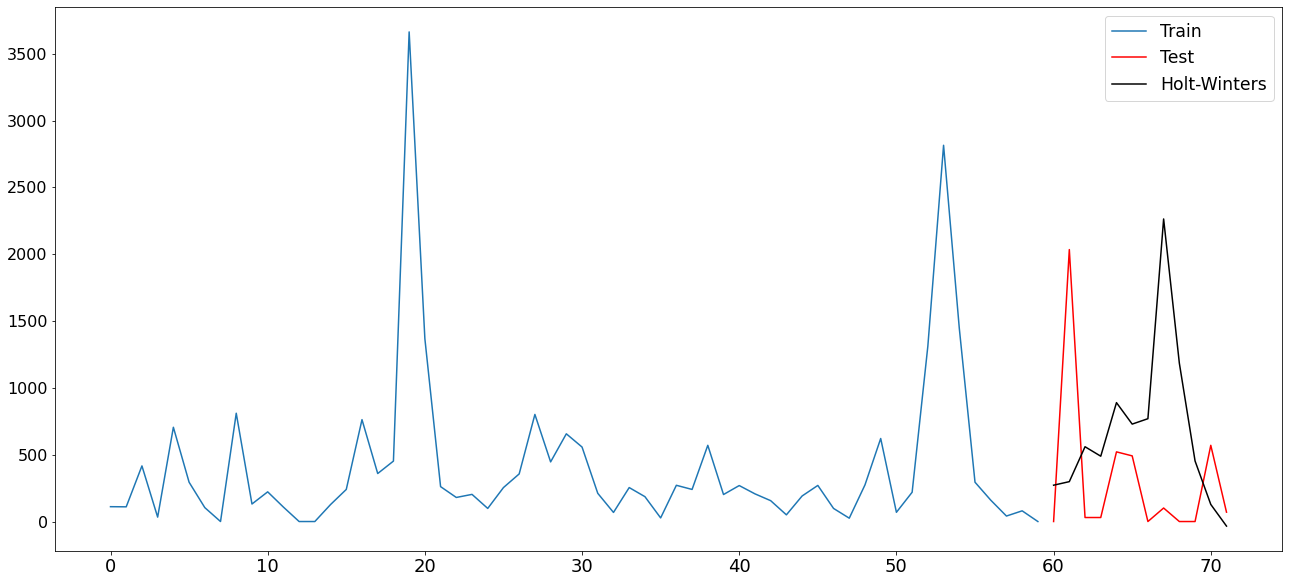

In [39]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

Prohpet

In [44]:
# pivot sold to and material
merge_gb_pivot = pd.pivot_table(merge_gb_df,
                           values = 'Invoiced Quantity',
                           index = 'Month',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

merge_gb_pivot = merge_gb_pivot.reset_index()
merge_gb_pivot['Month'] = to_datetime(merge_gb_pivot['Month'])
merge_gb_pivot = merge_gb_pivot.set_index('Month')
print(merge_gb_pivot)

Material    IB00095000  IB00095100  IB00099900  IB00100000  IB00136200  \
Month                                                                    
2016-01-01           0           0           0           0           0   
2016-02-01           0           0           0           0           0   
2016-03-01           0           0           0           0           0   
2016-04-01           0           0           0           0           0   
2016-05-01           0           0           0           0           0   
...                ...         ...         ...         ...         ...   
2021-08-01           0           0          30           0           0   
2021-09-01           0           0          20           0         126   
2021-10-01           0           0          60           0           0   
2021-11-01           0           0           0           0           0   
2021-12-01           0           0           0           0           0   

Material    IB00137300  IB00139800  I

In [57]:
sales_top1_df = merge_gb_pivot[['TB96805000']]
df = sales_top1_df.reset_index()
df.to_csv("Output/TW_AM_History.csv")

In [58]:
m = Prophet(seasonality_mode='multiplicative')
df = sales_top1_df.iloc[:,each].to_frame().reset_index()
material = df.columns[1]
df.columns = ['ds', 'y']
m.fit(df)
future = m.make_future_dataframe(periods=24, freq='MS')

fcst = m.predict(future)
#     fig = m.plot(fcst)
fcst[{'ds', 'yhat'}]

df2 = fcst[{'ds', 'yhat'}]
df2.columns = [material, 'Month']
df2.to_csv("Output/TW_AM_24mo_Prophet_FCST.csv")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


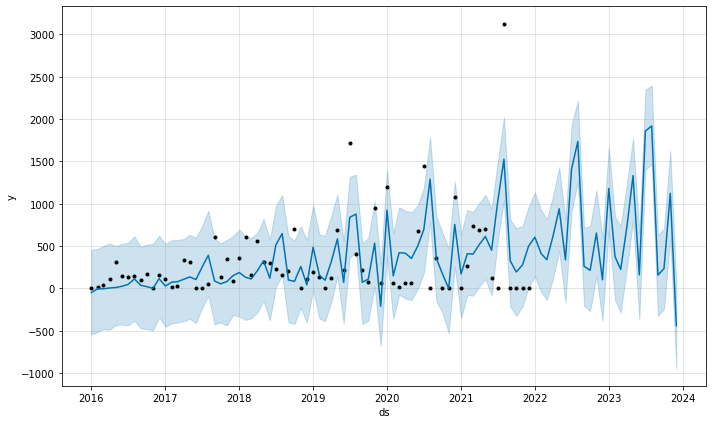

In [61]:
# display the most critical output columns from the forecast
fcst[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = m.plot(fcst)

OTHER

In [32]:
# iterate through each column and apply PROPHET method
# for each in range(sales_df_pivot.shape[1]):
#     df['ds'] = sales_df_pivot['Date']
#     y = sales_df_pivot.iloc([:, each])
#     df['y'] = y

for each in range(merge_gb_pivot.shape[1]):
    m = Prophet(seasonality_mode='multiplicative')
    df = merge_gb_pivot.iloc[:,each].to_frame().reset_index()
    material = df.columns[1]
    df.columns = ['ds', 'y']
    m.fit(df)
    future = m.make_future_dataframe(periods=24, freq='MS')

    fcst = m.predict(future)
#     fig = m.plot(fcst)
    fcst[{'ds', 'yhat'}]
    
    df2 = fcst[{'ds', 'yhat'}]
    df2.columns = [material, 'Month']
    df2[material] = df2[material].round(0).astype(int)
    df2.set_index('Date')
    
    df3 = merge_gb_pivot.merge(df2, on='Date', how='outer', suffixes=(None,'_y'))
    df3[material] = df3.loc[df3[material] == np.NaN, material] = df3[material+'_y']
    df3 = df3.drop(columns=[material+'_y'])
    
    df3.to_csv("Data/TW_AM_24mo_Prophet_FCST.csv")

ParserError: day is out of range for month: 0

In [47]:
df3.head(20)

,Date,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,IB00139800,IB00140000,IB00140200,...,TB96906000,TB96906100,TB96908000,TB96908100,TB96909000,TB96909100,TB96910000,TB96910100,TB96962000,TB96962100
0,2016-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-38
1,2016-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-58
2,2016-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11
3,2016-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,2016-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,2016-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4
6,2016-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,101.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
7,2016-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,377.0,0.0,30.0,0.0,30.0,0.0,30.0,0.0,0
8,2016-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,393.0,62.0,116.0,115.0,110.0,130.0,75.0,0.0,0
9,2016-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,25.0,312.0,406.0,307.0,386.0,301.0,320.0,0.0,-2


In [44]:
df3 = pd.read_csv("Data/TW_AM_24moFCST.csv")
df3.dtypes

Unnamed: 0      int64
Date           object
IB00095000    float64
IB00095100    float64
IB00099900    float64
               ...   
TB96909100    float64
TB96910000    float64
TB96910100    float64
TB96962000    float64
TB96962100      int64
Length: 366, dtype: object

In [ ]:
### 

In [ ]:
# Below is just reference

In [4]:
# pivot sold to and material
sales_df_pivot = pd.pivot_table(sales_df_gb,
                           values = 'Invoiced Quantity',
                           index = 'Date',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

sales_df_pivot = sales_df_pivot.reset_index()
sales_df_pivot['Date'] = to_datetime(sales_df_pivot['Date'])
sales_df_pivot = sales_df_pivot.set_index('Date')
sales_df_pivot.head()

Material,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# iterate through each column and apply prophet method
# for each in range(sales_df_pivot.shape[1]):
#     df['ds'] = sales_df_pivot['Date']
#     y = sales_df_pivot.iloc([:, each])
#     df['y'] = y

for each in range(sales_df_pivot.shape[1]):
    m = Prophet(seasonality_mode='multiplicative')
    df = sales_df_pivot.iloc[:,each].to_frame().reset_index()
    material = df.columns[1]
    df.columns = ['ds', 'y']
    m.fit(df)
    future = m.make_future_dataframe(periods=24, freq='MS')

    fcst = m.predict(future)
#     fig = m.plot(fcst)
    fcst[{'ds', 'yhat'}]
    
    df2 = fcst[{'ds', 'yhat'}]
    df2.columns = [material, 'Date']
    df2[material] = df2[material].round(0).astype(int)
    df2.set_index('Date')
    
    df3 = sales_df_pivot.merge(df2, on='Date', how='outer', suffixes=(None,'_y'))
    df3[material] = df3.loc[df3[material] == np.NaN, material] = df3[material+'_y']
    df3 = df3.drop(columns=[material+'_y'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

In [13]:
df3.head(20)

,Date,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
0,2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
1,2015-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
2,2015-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56
3,2015-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
4,2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43
5,2015-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42
6,2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
7,2015-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
8,2015-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42
9,2015-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30


,Date,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
82,2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
83,2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN,NaN,NaN
84,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-25,NaN,NaN,NaN
85,2022-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-40,NaN,NaN,NaN
86,2022-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-28,NaN,NaN,NaN
87,2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4,NaN,NaN,NaN
88,2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-13,NaN,NaN,NaN
89,2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-6,NaN,NaN,NaN
90,2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-5,NaN,NaN,NaN
91,2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN,NaN,NaN


In [ ]:
# rename specs Object column to Material
specs1_df = specs_df.rename(columns={"Object":"Material"})

# merge specs into sales data frame
merged_df = pd.merge(sales_df, specs1_df, on="Material", how="left")

In [21]:
# group and pivot invoiced quantity by date, sold-to, and material
# split Month into separate month and year components
sales_df[["Month", "Year"]] = sales_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
sales_df["Date"] = sales_df["Year"] + "-" + sales_df["Month"]

# group by date, sold-to, material
sales_df_gb = sales_df.groupby(
    ["Date","Sold-to pt", "Material"],
)[["Invoiced Quantity"]].sum()

# pivot sold to and material
sales_df_pivot = pd.pivot_table(sales_df_gb,
                                values = 'Invoiced Quantity',
                                index = 'Date',
                                columns = ['Sold-to pt', 'Material'],
                                aggfunc=np.sum,
                                fill_value = 0
                               )

sales_df_pivot.head(20)

Sold-to pt    1000014                                                         \
Material   IB00026200 IB00100000 IB00136200 IB75077200 IB75501000 IB75665000   
Date                                                                           
2015-01             0          0          0          0          0          0   
2015-02             0          0          0          0          0          0   
2015-03             0          0          0          0          0          0   
2015-04             0          0          0          0          0          0   
2015-05             0          0          0          0          0          0   
2015-06             0          0          0          0          0          0   
2015-07             0          0          0          0          0          0   
2015-08             0          0          0          0          0          0   
2015-09             0          0          0          0          0          0   
2015-10             0          0          0          0          0          0   
2015-11             0          0          0          0          0          0   
2015-12             0          0          0          0          0          0   
2016-01             0          0          0          0          0          0   
2016-02             0          0          0          0          0          0   
2016-03             0          0          0          0          0          0   
2016-04             0          0          0          0          0          0   
2016-05             0          0          0          0          0          0   
2016-06             0          0          0          0          0          0   
2016-07             0          0          0          0          0          0   
2016-08             0          0          0          0          0          0   

Sold-to pt                                              ...    2000030  \
Material   TB00017200 TB00017400 TB00017500 TB00017600  ... TB96906500   
Date                                                    ...              
2015-01             0          0          0          0  ...          0   
2015-02             0          0          0          0  ...          0   
2015-03             0          0          0          0  ...          0   
2015-04             0          0          0          0  ...          0   
2015-05             0          0          0          0  ...          0   
2015-06             0          0          0          0  ...          0   
2015-07             0          0          0          0  ...          0   
2015-08             0          0          0          0  ...          0   
2015-09             0          0          0          0  ...          0   
2015-10             0          0          0          0  ...          0   
2015-11             0          0          0          0  ...          0   
2015-12             0          0          0          0  ...          0   
2016-01             0          0          0          0  ...          0   
2016-02             0          0          0          0  ...          0   
2016-03             0          0          0          0  ...          0   
2016-04             0          0          0          0  ...          0   
2016-05             0          0          0          0  ...          0   
2016-06             0          0          0          0  ...          0   
2016-07             0          0          0          0  ...          0   
2016-08             0          0          0          0  ...          0   

Sold-to pt                                                                    \
Material   TB96906600 TB96908000 TB96908100 TB96909000 TB96909100 TB96910000   
Date                                                                           
2015-01             0          0          0          0          0          0   
2015-02             0          0          0          0          0          0   
2015-03             0          0          0          0  

In [ ]:
# reduce down to necessary columns
reduced_df = merged_df[["Material", "Sold-to pt", "Month", "Invoiced Quantity", 
                        "Product hierarchy.1", "Application_x", "Tire Size", "Ply Construction",
                        "Bead", "Color", "TPI - Threads per inch", "Compound", "Technology"
                       ]]

# rename columns
reduced_df = reduced_df.rename(columns={"Product hierarchy.1":"Product hierarchy",
                                        "Application_x":"Application"})

# split tire size by diameter (before x) and width (after x)
reduced_df[["Diameter", "Width"]] = reduced_df["Tire Size"].str.split("X", n=1, expand=True)

# splite Month into separate month and year components
reduced_df[["Month", "Year"]] = reduced_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
reduced_df["Date"] = reduced_df["Year"] + "/" + reduced_df["Month"]

# strip erroneous text from diameter and width
reduced_df["Diameter"] = reduced_df["Diameter"].str.replace(r'"','')
reduced_df["Width"] = reduced_df["Width"].str.replace(r'"','')

# drop application Tubes and MVS
# reduced_df = reduced_df[reduced_df["Application"].str.contains("TUBE|MVS")==False]

#Displaying Cleaned Dataframe
reduced_df

# Output to excel for review
# reduced_df.to_excel('Output/output.xlsx')

In [ ]:
# groupby date, material
groupby_df = reduced_df.groupby(["Date","Material"],
                              as_index=False)[["Date","Material","Invoiced Quantity"]].sum()

for each in groupby_df["Material"]
bymaterial_df = groupby_df

In [ ]:
# Holt Winters ETS forecasting for total sales by month

fc_df = soldto_df

fit_model = ETS(fc_df["Invoiced Quantity"],trend="mul",seasonal="mul",seasonal_periods=12).fit()

fc_future = fit_model.forecast(24).round()

fc_df["Forecast"] = fit_model.fittedvalues()

fc_df["Forecast"] = fc_df["Forecast"].round()

fc_df
# # append forecasted values onto onto model
# fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# # merge forecasted dataframe with actual sales data frame
# fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

# print(f"MSE: {mse_test}")
# print(f"MAE: {mae_test}")

In [ ]:
# group by material create a time series for each material for invoiced quantity by month

date_df = reduced_df.groupby(["Date"], as_index = False)[["Date", "Invoiced Quantity"]].sum()                     

# Prelimiary plot to quickly visualize overall
plt.plot(date_df["Date"], date_df["Invoiced Quantity"])
plt.title("Total sales quantity by month")

plt.show()
plt.savefig("Output/Total sales quantity by month.png")

In [ ]:
# group by year and month then sum invoiced quantity
year_month_df = reduced_df.groupby(["Year", "Month"],
                                   as_index = False)[["Year", "Month", "Invoiced Quantity"]].sum()

year_month_df

In [ ]:
# Holt Winters ETS forecasting for total sales by month

fc_df = year_month_df

fc1519_df = fc_df.loc[(fc_df['Year'] == "2015")|
          (fc_df['Year'] == "2016")|
          (fc_df['Year'] == "2017")|
          (fc_df['Year'] == "2018")|
          (fc_df['Year'] == "2019"), :]

fit_model = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit()

fc2021 = fit_model.forecast(24).round()

fc1519_df["Forecast"] = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit().fittedvalues

fc1519_df["Forecast"] = fc1519_df["Forecast"].round()

# plot the forecasted model
fc_df["Invoiced Quantity"].plot(legend=True, label="Actual")
fc2021.plot(legend=True, label="Predicted")
fc1519_df["Forecast"].plot(legend=True, label="HWTES",
                          title="Forecasted Monthly Sales Volume (2015-2021)",
                          ylabel="Quantity Sold",
                          xlabel="Month")

plt.savefig("Output/Forecasted Quantity by Month.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# merge forecasted dataframe with actual sales data frame
fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

# original data ends at 2021/10 so adding dates to the bottom
fcm_df.at[82,"Year"]= "2021"
fcm_df.at[83,"Year"]= "2021"
fcm_df.at[82,"Month"]= "11"
fcm_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [ ]:
# Group forecasts by year
fcm_yr_df = fcm_df.groupby(["Year"],
                           as_index = False)[["Year","Invoiced Quantity","Forecast"]].sum()

fcm_yr_df.to_csv("Output/forecast_by_year.csv", index = False)

fcm_yr_df

In [ ]:
#chi testing data from combined_year
forcast_chi = {'year': ['2020','2021'],
         'expected': [184502,192619], 'observed':[168569,315350]}

forcast_chi_df = pd.DataFrame(forcast_chi)

forcast_chi_df.to_csv("Output/forcast_chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

pvalue = st.chisquare(forcast_chi_df['observed'], forcast_chi_df['expected'])

print(critical_value)
print(pvalue)

forcast_chi_df

In [ ]:
#chi testing data from combined_year
forcast_chi = {'year': ['2018','2019'],
         'expected': [170569.0,177373.0], 'observed':[175695,168569.0]}

forcast_chi_df = pd.DataFrame(forcast_chi)

forcast_chi_df.to_csv("Output/forcast_chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

pvalue = st.chisquare(forcast_chi_df['observed'], forcast_chi_df['expected'])

print(critical_value)
print(pvalue)

forcast_chi_df

In [ ]:
# Find years and months, 
# create a dataframe containing the summed quantities for each date 
# with months in rows and years in columns

years = year_month_df["Year"].unique()
months = {"Month": year_month_df["Month"].unique()}
yearly_df = pd.DataFrame(months)

for each in years:
    df = year_month_df.loc[year_month_df['Year'] == each]
    df = df[["Month","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    yearly_df = pd.merge(yearly_df, df, on="Month", how="left" )      

yearly_df

In [ ]:
# plot quantity by month for each year
for each in years:
    plt.plot(yearly_df["Month"], yearly_df[each], label = each)

plt.title("Quantity Sold by Month")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.legend(title="Year")
plt.title("Yearly Quantity vs over the Months")
plt.grid()
plt.show()

plt.savefig("Output/YearlyQuantitybymonthyear.png")

In [ ]:
#using .groupby() and .sum() to get the year to invoiced quantity total
combined_year = year_month_df.groupby(['Year'])['Invoiced Quantity'].sum().reset_index()
combined_year

In [ ]:
#dropping year 2020 and 2021 during the covid year before calculating lineregression.
combined_year_drop = combined_year.drop([5,6])
combined_year_drop

In [ ]:
#setting up the linear regression and line for the scatter plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year_drop["Year"].astype(int),combined_year_drop["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year_drop["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year_drop.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year_drop['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (pre-covid)")
plt.savefig("Output/Invoiced Quantity vs Year (pre-covid).png")
plt.show()

In [ ]:
#setting up the linear regression and line for the scatter plot for 7 years including covid
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year["Year"].astype(int),combined_year["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (with covid)")
plt.savefig("Output/Invoiced Quantity vs Year (with covid).png")
plt.show()

In [ ]:
# quantity sold grouped by application

application_df = reduced_df.groupby(["Application","Year"],
                                   as_index = False)[["Application","Year","Invoiced Quantity"]].sum()

# arrange chart with years in the columns
years = application_df["Year"].unique()
applications = {"Application": application_df["Application"].unique()}
application_year_df = pd.DataFrame(applications)

for each in years:
    df = application_df.loc[application_df['Year'] == each]
    df = df[["Application","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    application_year_df = pd.merge(application_year_df, df, on="Application", how="left" )      

application_year_df.to_csv("Output/application_year_df.csv", index = False)
application_year_df

In [ ]:
# plot sales by application by year

application_year_df.set_index("Application").plot(kind='bar',figsize=(20,10), stacked = True)

plt.title("Quantity Sold by Application")
plt.xlabel('Application')
plt.ylabel('Invoiced Quantity')

plt.legend(['2015',
            '2016',
            '2017',
            '2018',
            '2019',
            '2020',
            '2021',
           ])
plt.title("Invoiced Quantity vs Application over the years")
plt.savefig("Output/Invoiced Quantity vs Application over the years.png")
plt.show()

In [ ]:
# group sales by for forecast application by year

diameter_df = reduced_df.groupby(["Application","Diameter","Year","Month"],
                                   as_index = False)[["Application","Diameter",
                                                      "Year","Month",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_275_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "27.5"]
diameter_29_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "29"]
diameter_275_df = diameter_275_df[["Year","Month","Invoiced Quantity"]].reset_index(drop=True)
diameter_275_df = diameter_275_df.rename(columns=({"Invoiced Quantity":"27.5"}))
diameter_29_df = diameter_29_df[["Invoiced Quantity"]].reset_index(drop=True)
diameter_29_df = diameter_29_df.rename(columns=({"Invoiced Quantity":"29"}))
year_diameter_df = diameter_275_df.merge(diameter_29_df,
                                         how='outer', left_index=True, right_index=True)

year_diameter_df

In [ ]:
# Holt Winters Triple Exponential Smoothing forecasting

fc_diameter_df = year_diameter_df

# filter out only 2015-2019 for training data
fc_diameter_1519_df = fc_diameter_df.loc[(fc_diameter_df['Year'] == "2015")|
                                         (fc_diameter_df['Year'] == "2016")|
                                         (fc_diameter_df['Year'] == "2017")|
                                         (fc_diameter_df['Year'] == "2018")|
                                         (fc_diameter_df['Year'] == "2019"), :]

# 27.5 forecast
fit_diameter_model_275 = ETS(fc_diameter_1519_df["27.5"],
                             trend="mul",seasonal="mul", damped_trend=True,
                             seasonal_periods=12).fit()

fc_diameter_2021_275 = fit_diameter_model_275.forecast(24).round()

fc_diameter_1519_df["27.5 Forecast"] = fit_diameter_model_275.fittedvalues

fc_diameter_1519_df["27.5 Forecast"] = fc_diameter_1519_df["27.5 Forecast"].round()


# 29 forecast
fit_diameter_model_29 = ETS(fc_diameter_1519_df["29"],
                            trend="mul",seasonal="mul", damped_trend=True,
                            seasonal_periods=12).fit()

fc_diameter_2021_29 = fit_diameter_model_29.forecast(24).round()

fc_diameter_1519_df["29 Forecast"] = fit_diameter_model_29.fittedvalues

fc_diameter_1519_df["29 Forecast"] = fc_diameter_1519_df["29 Forecast"].round()

# plot the forecasted model
fc_diameter_df["27.5"].plot(legend=True, label="27.5 Actual")
fc_diameter_2021_275.plot(legend=True, label="27.5 Predicted")
fc_diameter_df["29"].plot(legend=True, label="29 Actual")
fc_diameter_2021_29.plot(legend=True, label="29 Predicted")
plt.title("Forecasted Sales Volume 27.5 vs 29 (2015-2021)")
plt.ylabel("Quantity Sold")
plt.xlabel("Month")
plt.grid('both')
plt.show()

plt.savefig("Output/Forecasted Diameter.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc_diameter_1521_275_df = pd.DataFrame({"27.5 Forecast":fc_diameter_1519_df["27.5 Forecast"].append(fc_diameter_2021_275)})
fc_diameter_1521_29_df = pd.DataFrame({"29 Forecast":fc_diameter_1519_df["29 Forecast"].append(fc_diameter_2021_29)})

# merge forecasted dataframe with actual sales data frame
fcmd_df = fc_diameter_df.merge(fc_diameter_1521_275_df, how='outer', left_index=True, right_index=True)
fcmd_df = fcmd_df.merge(fc_diameter_1521_29_df, how='outer', left_index=True, right_index=True)

# original data ends at 2021/10 so manually adding dates to the bottom
fcmd_df.at[82,"Year"]= "2021"
fcmd_df.at[83,"Year"]= "2021"
fcmd_df.at[82,"Month"]= "11"
fcmd_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [ ]:
# Group forecasts by year
fcmd_yr_df = fcmd_df.groupby(["Year"],
                           as_index = False)[["Year",
                                              "27.5", "27.5 Forecast",
                                              "29", "29 Forecast"]].sum()

fcmd_yr_df['29 Actual %'] = (fcmd_yr_df['29'] / (fcmd_yr_df['29'] + fcmd_yr_df['27.5']) * 100).round(1)
fcmd_yr_df['29 Predicted %'] = (fcmd_yr_df['29 Forecast'] / (fcmd_yr_df['29 Forecast'] + fcmd_yr_df['27.5 Forecast']) * 100).round(1)

fcmd_yr_df.to_csv("Output/diameter_forecast_by_year.csv", index = False)

fcmd_yr_df = fcmd_yr_df.set_index("Year")

fcmd_yr_df

In [ ]:
# plot forecast vs actual

fcmd_yr_df['29 Predicted %'].plot(legend=True, label="% 29 Predicted")
fcmd_yr_df['29 Actual %'].plot(legend=True, label="% 29 Actual")

plt.xlabel('Year')
plt.ylabel('% of 29 vs 27.5')
plt.title('% of 29 diameter vs 27.5 by year')
plt.savefig("Output/29v275.png")
plt.grid('both')
plt.show()

In [ ]:
#chi testing data from combined_year
chi = {'year': ['2019', '2020'],
         'observed': [59.8,64.4], 'expected':[55.5,54.0]
        }

chi_df = pd.DataFrame(chi)

chi_df.to_csv("Output/chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

print(f"Critical Value = {critical_value}")
print(st.chisquare(chi_df['observed'], chi_df['expected']))

chi_df

In [ ]:
# Secondary diameter group by specifically for plot below
diameter_df = reduced_df.groupby(["Application","Diameter","Year"],
                                   as_index = False)[["Application","Diameter","Year",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_mountain_df = diameter_mountain_df[["Diameter","Year","Invoiced Quantity"]]

years = diameter_mountain_df["Year"].unique()
diameters = {"Diameter": diameter_mountain_df["Diameter"].unique()}
diameter_year_df = pd.DataFrame(diameters)

for each in years:
    df = diameter_mountain_df.loc[diameter_mountain_df['Year'] == each]
    df = df[["Diameter","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    diameter_year_df = pd.merge(diameter_year_df, df, on="Diameter", how="left" )

# diameter_year_df

year_diameter_df = diameter_year_df.transpose()

year_diameter_df.columns=year_diameter_df.iloc[0]
year_diameter_df = year_diameter_df[1:]
year_diameter_df = year_diameter_df.rename(columns={"Diameter":"Year"})

year_diameter_df.to_csv("Output/year_diameter_df.csv", index = False)

year_diameter_df

In [ ]:
# plot quantity by diameter for each year
diameter_year_df.set_index("Diameter").transpose().plot(kind='bar')

plt.xlabel('Year')
plt.ylabel('Invoiced Quantity')
plt.title('Year vs Invoiced Quantity')
plt.savefig("Output/Year vs Invoiced Quantity.png")
plt.show()

In [ ]:
#Percent change usind .pct_change()
pct_chng_diameter = diameter_year_df.set_index("Diameter").transpose().pct_change().fillna(0)

pct_chng_diameter.to_csv("Output/pct_chng_diameter.csv", index = False)

pct_chng_diameter

In [ ]:
#figure of percent change
pct_chng_diameter.plot()
plt.xlabel('Year')
plt.ylabel('Percent Change in Quantity')
plt.title('Year vs Percent Change in Quantity')
plt.savefig("Output/Year vs Percent Change in Quantity.png")